In [1]:
using Revise
using Pkg
Pkg.develop(path="/home/stephenz/stephenz/locaTE.jl")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
using NPZ
using locaTE
using NearestNeighbors
using Graphs
using GraphSignals
using SparseArrays
using LinearAlgebra
using Plots
using StatsBase
using CUDA

In [3]:
DATA_DIR = "../../data/HSPC/"
X = npzread(string(DATA_DIR, "X.npy"));
X_pca = npzread(string(DATA_DIR, "X_pca.npy"));
X_umap = npzread(string(DATA_DIR, "X_umap.npy"));
P = npzread(string(DATA_DIR, "P_kappavelo.npy"));
dpt = npzread(string(DATA_DIR, "dpt.npy"));
R = npzread(string(DATA_DIR, "R.npy"));
C = npzread(string(DATA_DIR, "C.npy"));

In [4]:
# construct kNN and Laplacian
kdtree = KDTree(X_pca')
idxs, dists = knn(kdtree, X_pca', 25);
A = spzeros(size(X_pca, 1), size(X_pca, 1));
for (i, j) in enumerate(idxs)
    A[i, j] .= 1.0
end
L = sparse(normalized_laplacian(max.(A, A'), Float64));

In [5]:
TE = npzread("TE_locate_kappa.npy");

In [6]:
using Random
using NNlib

In [45]:
# NMF
qnorm(x, q) = x ./ quantile(vec(x), q)
Cg = cor(X).^2; Cg[diagind(Cg)] .= 0
L = sparse(npzread("L_locate_kappa.npy"));

In [46]:
Random.seed!(0)
U, V, trace = fitnmf(cu(relu.(qnorm(TE, 0.9))),
                     [I(size(TE, 1)), I(size(TE, 2))], 1e-3*I + L,
                     cu(repeat(vec(Cg), 1, size(X, 1))'),
                     8; 
                     α = 10.0,
                     β = 0.0, 
              λ = [1, 1],
              μ = [1, 1],
              iter = 10_000, initialize = :nmf, print_iter = 50, dictionary = false, η = 1.0);
G_nmf = Array(U*V');
U = Array(U); V = Array(V);
# rescale U, V
U .*= mean(V; dims = 1)
V ./= mean(V; dims = 1);
npzwrite("U.npy", U)
npzwrite("V.npy", V)

[ Info: Initializing NMF decomposition with nmf
Progress: 100%|█████████████████████████████████████████| Time: 0:07:01


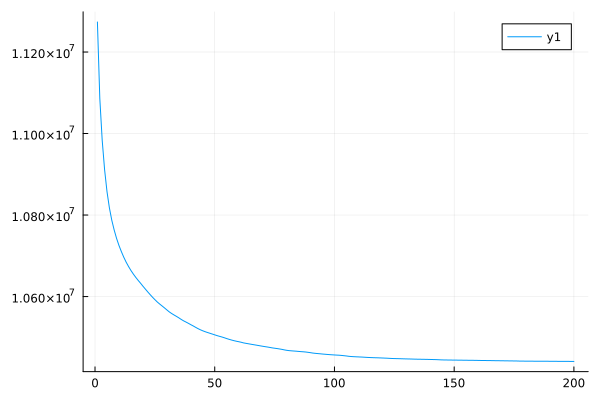

In [47]:
plot(trace)

In [35]:
# NTF
Cg = cor(X).^2; Cg[diagind(Cg)] .= 0
S, A, trace = fitntf(cu(reshape(qnorm(TE, 0.9), :, size(X, 2), size(X, 2))),
                     [Array{Float32}(I(size(X, 1))), Array{Float32}(I(size(X, 2))), Array{Float32}(I(size(X, 2)))], Array{Float32}(1e-3*I + L), 
                     cu(repeat(reshape(Cg, 1, size(X, 2), size(X, 2)), size(X, 1))), 
                     [1, 1, 1],
                     [1, 1, 1],
                     10.0,
                     0.0,
                     36; iter = 500, dictionary = false, η = 1.0);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


In [36]:
for i = 1:length(A)
    npzwrite("A_$i.npy", Array(A[i]))
end

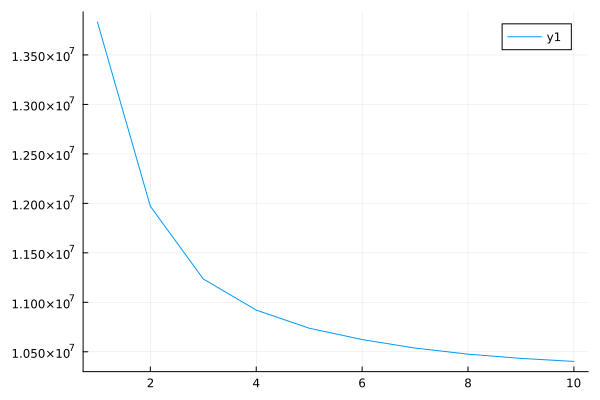

In [37]:
plot(trace)